In [1]:
from src.data_utils import *
from src.evaluate_utils import *
from src.train import *
from src.data_utils import construct_data_loaders, tokenize_text
from src.train import train_model
from IPython.display import clear_output
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from peft import LoraModel, LoraConfig, TaskType, get_peft_model

In [3]:
train_dataset, test_dataset = construct_data_loaders("data/SwahiliNewsClassificationDataset.csv")

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
train_dataset = tokenize_text(train_dataset, tokenizer)
test_dataset = tokenize_text(test_dataset, tokenizer)

model = AutoModelForSequenceClassification.from_pretrained("results/checkpoint-2700", num_labels=2)

config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.01
)

model = get_peft_model(model, config, "default")

c:\Users\Muhammad Sahal\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
outputs = model(input_ids = test_dataset[4]['input_ids'].unsqueeze(0), attention_mask = test_dataset[4]['attention_mask'].unsqueeze(0), 
                output_attentions = True)

In [55]:
def merge_subword_tokens(tokens, attentions):
    words = []
    word_attentions = []
    current_word = ''
    current_attention = 0.0
    current_token_count = 0

    for token, attention in zip(tokens, attentions):
        if token.startswith('##'):
            current_word += token[2:]  # Remove '##' and append to current word
            current_attention += attention
            current_token_count += 1
        else:
            if current_word != '':
                # Append the previous word and its averaged attention
                words.append(current_word)
                word_attentions.append(current_attention / current_token_count)
            current_word = token  # Start a new word
            current_attention = attention
            current_token_count = 1

    # Append the last word
    if current_word != '':
        words.append(current_word)
        word_attentions.append(current_attention / current_token_count)

    return words, word_attentions

In [58]:
# Average over heads in each layer
import torch
attentions = outputs.attentions
avg_attn_per_layer = [attn.mean(dim=1) for attn in attentions]

# Stack and average over layers
stacked_avg_attn = torch.stack(avg_attn_per_layer)  # Shape: (num_layers, batch_size, seq_len, seq_len)
mean_attn = stacked_avg_attn.mean(dim=0)  # Shape: (batch_size, seq_len, seq_len)

# Get attention from [CLS] token to all tokens
cls_attn = mean_attn[0, 0, :]  # Shape: (seq_len,)
tokens = tokenizer.convert_ids_to_tokens(test_dataset[0]['input_ids'])

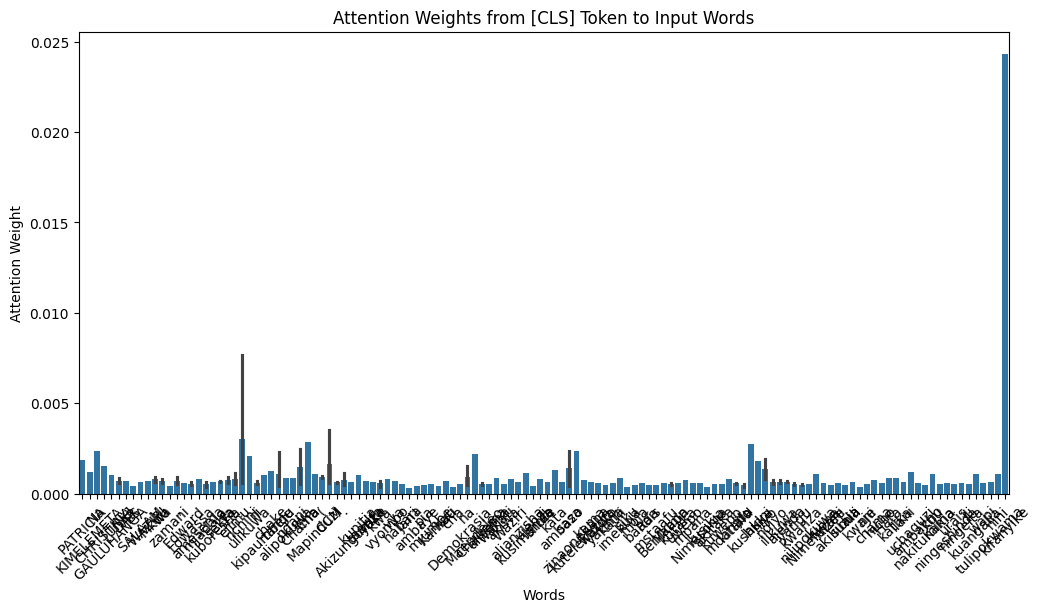

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert attention weights to numpy array
cls_attn_weights = cls_attn.detach().numpy()
seq_len = test_dataset[4]['attention_mask'].sum().item()
tokens = tokens[:seq_len]
cls_attn_weights = cls_attn_weights[:seq_len]
words, word_attentions = merge_subword_tokens(tokens, cls_attn_weights)

# Plot the attention weights
plt.figure(figsize=(12, 6))
sns.barplot(x=words[1:], y=word_attentions[1:])
plt.title('Attention Weights from [CLS] Token to Input Words')
plt.xlabel('Words')
plt.ylabel('Attention Weight')
plt.xticks(rotation=45)
plt.show()

In [4]:
from datasets import load_dataset
from collections import Counter

# Load the dataset
dataset = load_dataset('stanford-oval/ccnews', name='2018', streaming=True)

# Access the train split
train_dataset = dataset['train']
print(train_dataset)
dataset = train_dataset
# Initialize language counter
language_counts = Counter()

# Iterate over the dataset to count languages
for example in dataset:
    language = example['language']
    language_counts[language] += 1

# Print the summary of languages
print("Summary of languages in the dataset:")
for language, count in language_counts.items():
    print(f"Language: {language}, Number of rows: {count}")

# Function to summarize categories for a given language
def summarize_categories_by_language(dataset, target_language):
    category_counts = Counter()
    
    # Iterate over the dataset
    for example in dataset:
        if example['language'] == target_language:
            categories = example['categories']
            if categories:
                # Handle cases where 'categories' might be None or empty
                if isinstance(categories, list):
                    for category in categories:
                        category_counts[category] += 1
                else:
                    category_counts[categories] += 1
            else:
                category_counts['Unknown'] += 1
    
    # Print the summary of categories
    print(f"\nSummary of categories for language '{target_language}':")
    for category, count in category_counts.items():
        print(f"Category: {category}, Number of rows: {count}")

# Input language code from the user or define it directly
target_language = input("\nEnter the language code to summarize categories (e.g., 'en'): ").strip()

# Summarize categories for the given language
summarize_categories_by_language(dataset, target_language)


Resolving data files:   0%|          | 0/479 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

IterableDataset({
    features: ['requested_url', 'plain_text', 'published_date', 'title', 'tags', 'categories', 'author', 'sitename', 'image_url', 'language', 'language_score', 'responded_url', 'publisher', 'warc_path', 'crawl_date'],
    n_shards: 43
})
Summary of languages in the dataset:
Language: en, Number of rows: 14264780
Language: ro, Number of rows: 629847
Language: pt, Number of rows: 1657488
Language: tr, Number of rows: 1178429
Language: de, Number of rows: 3119317
Language: fa, Number of rows: 114105
Language: sk, Number of rows: 135032
Language: es, Number of rows: 6270490
Language: fr, Number of rows: 1643300
Language: it, Number of rows: 2108014
Language: sl, Number of rows: 63681
Language: sv, Number of rows: 508067
Language: nl, Number of rows: 700654
Language: ar, Number of rows: 1027675
Language: uk, Number of rows: 507852
Language: ur, Number of rows: 174014
Language: bg, Number of rows: 192594
Language: ru, Number of rows: 2482405
Language: fi, Number of rows: 22

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: af5e5f35-c937-44f5-a08b-235c7d5b947e)')' thrown while requesting GET https://huggingface.co/datasets/stanford-oval/ccnews/resolve/d733e654c9a506df519e1a166a86c118c7657ce4/2018_0028.parquet
Retrying in 1s [Retry 1/5].



Summary of categories for language 'am':
Category: ዜና, Number of rows: 3790
Category: 4.1, Number of rows: 5
Category: Unknown, Number of rows: 44
Category: AMHARIC NEWS, Number of rows: 1
Category: AddisAdmass, Number of rows: 1
Category: 4.7, Number of rows: 1
Category: News, Number of rows: 5
Category: Africa, Number of rows: 1
Category: ስፖርት, Number of rows: 41
Category: Media, Number of rows: 1
